$Loan$ $Eligibility$ $Prediction$

In [19]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
from logging.handlers import TimedRotatingFileHandler
warnings.filterwarnings('ignore')

In [20]:
def setup_logger(name: str, log_filename: str | Path, level = logging.INFO) -> logging.Logger:
    ''' Setup a dedicated timedrotatingfilehandler logging system that logs information to both file and console

    Args: 
        name : logger name (e.g. EDA, preprocessing, feature_engineering)
        log_filename: Log output file
        level: Logging level (e.g. INFO, WARNING, ERROR, DEBUG)

    Examples:
        log = setup_logger(name="EDA",log_filename="logs/EDA_pipeline.log", level=logging.INFO)
        log.info("Dedicated logging system setup successful")
    '''
    log = logging.getLogger(name)
    # prevent adding handlers multiple times if handlers already exist
    if log.handlers:
        return log
    
    formatter = logging.Formatter(
        "%(asctime)s - %(levelname)s : %(message)s",
        datefmt='%Y-%m-%d %H:%M:%S'
        )
    # Time rotating file handler
    file_handler = TimedRotatingFileHandler(
        filename=log_filename,
        when='midnight',
        interval=1,
        backupCount=7
    )
    file_handler.suffix = "_%Y%m%d"
    file_handler.setFormatter(formatter)
    
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)

    log.propagate = False # don't propagate to root logger
    log.setLevel(level)

    log.addHandler(file_handler)
    log.addHandler(console_handler)
    
    return log

In [21]:
log = setup_logger(name='notebook_eda', log_filename='../logs/notebook_eda.log')

`Basic Descriptive Summary`

In [22]:
try:
    df = pd.read_csv('../data/raw/LEP.csv')
except FileNotFoundError:
    log.error('File not found! Check filepath and try again')
    raise
except Exception as e:
    log.error(f'Error parsing CSV file: {e}',exc_info=True)

In [23]:
df.head()

,Customer_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,569,Female,No,0,Graduate,No,2378,0.0,9,360,1,Urban,N
1,15,Male,Yes,2,Graduate,No,1299,1086.0,17,120,1,Urban,Y
2,95,Male,No,0,Not Graduate,No,3620,0.0,25,120,1,Semiurban,Y
3,134,Male,Yes,0,Graduate,Yes,3459,0.0,25,120,1,Semiurban,Y
4,556,Male,Yes,1,Graduate,No,5468,1032.0,26,360,1,Semiurban,Y


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         614 non-null    int64  
 1   Gender              614 non-null    object 
 2   Married             614 non-null    object 
 3   Dependents          614 non-null    int64  
 4   Education           614 non-null    object 
 5   Self_Employed       614 non-null    object 
 6   Applicant_Income    614 non-null    int64  
 7   Coapplicant_Income  614 non-null    float64
 8   Loan_Amount         614 non-null    int64  
 9   Loan_Amount_Term    614 non-null    int64  
 10  Credit_History      614 non-null    int64  
 11  Property_Area       614 non-null    object 
 12  Loan_Status         614 non-null    object 
dtypes: float64(1), int64(6), object(6)
memory usage: 62.5+ KB


In [25]:
log.info(f'Number of observations: {df.shape[0]}')

2025-11-07 14:38:33 - INFO : Number of observations: 614


In [26]:
log.info(f'Number of features: {df.shape[1]}')

2025-11-07 14:38:33 - INFO : Number of features: 13


In [27]:
df.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
Customer_ID,614.0,307.500000,177.390811,1.0,154.25,307.5,460.75,614.0
Dependents,614.0,0.856678,1.216651,0.0,0.00,0.0,2.00,4.0
Applicant_Income,614.0,5403.459283,6109.041673,150.0,2877.50,3812.5,5795.00,81000.0
Coapplicant_Income,614.0,1621.245798,2926.248369,0.0,0.00,1188.5,2297.25,41667.0
Loan_Amount,614.0,142.022801,87.083089,9.0,98.00,125.0,164.75,700.0
Loan_Amount_Term,614.0,338.892508,69.716355,12.0,360.00,360.0,360.00,480.0
Credit_History,614.0,0.850163,0.357203,0.0,1.00,1.0,1.00,1.0


In [28]:
df.describe(exclude=np.number).T

,count,unique,top,freq
Gender,614,2,Male,499
Married,614,2,Yes,399
Education,614,2,Graduate,480
Self_Employed,614,2,No,523
Property_Area,614,3,Semiurban,233
Loan_Status,614,2,Y,422


`Numerical Columns`

In [ ]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
log.info(f'NUMERICAL COLUMNS')
log.info('='*30)
log.info(numeric_columns)
log.info('='*30)

2025-11-07 14:38:33 - INFO : ['Customer_ID', 'Dependents', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Loan_Amount_Term', 'Credit_History']


In [ ]:
log.info('='*50)
for i, col in enumerate(numeric_columns,1):
    log.info(f'{i}. {col:<20} | Min: {df[col].min():<7} | Max: {df[col].max()}')
log.info('='*50)

2025-11-07 14:38:22 - INFO : ==================================================
2025-11-07 14:38:22 - INFO : 0. Customer_ID          | Min: 1       | Max: 614
2025-11-07 14:38:22 - INFO : 1. Dependents           | Min: 0       | Max: 4
2025-11-07 14:38:22 - INFO : 2. Applicant_Income     | Min: 150     | Max: 81000
2025-11-07 14:38:22 - INFO : 3. Coapplicant_Income   | Min: 0.0     | Max: 41667.0
2025-11-07 14:38:22 - INFO : 4. Loan_Amount          | Min: 9       | Max: 700
2025-11-07 14:38:22 - INFO : 5. Loan_Amount_Term     | Min: 12      | Max: 480
2025-11-07 14:38:22 - INFO : 6. Credit_History       | Min: 0       | Max: 1
2025-11-07 14:38:22 - INFO : ==================================================


`Categorical Columns`

In [ ]:
log.info('CATEGORICAL COLUMNS')
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
log.info('='*30)
log.info(categorical_cols)
log.info('='*30)

2025-11-07 14:44:27 - INFO : ==============================
2025-11-07 14:44:27 - INFO : ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
2025-11-07 14:44:27 - INFO : ==============================


In [33]:
log.info('='*30)
for i, col in enumerate(categorical_cols,1):
    uniques = df[col].unique()
    log.info(f'{i}. {col:<15} | Unique : {df[col].nunique()} | Examples: {uniques[:6]}')
log.info('='*30)

2025-11-07 14:50:06 - INFO : ==============================
2025-11-07 14:50:06 - INFO : 1. Gender          | Unique : 2 | Examples: ['Female' 'Male']
2025-11-07 14:50:06 - INFO : 2. Married         | Unique : 2 | Examples: ['No' 'Yes']
2025-11-07 14:50:06 - INFO : 3. Education       | Unique : 2 | Examples: ['Graduate' 'Not Graduate']
2025-11-07 14:50:06 - INFO : 4. Self_Employed   | Unique : 2 | Examples: ['No' 'Yes']
2025-11-07 14:50:06 - INFO : 5. Property_Area   | Unique : 3 | Examples: ['Urban' 'Semiurban' 'Rural']
2025-11-07 14:50:06 - INFO : 6. Loan_Status     | Unique : 2 | Examples: ['N' 'Y']
2025-11-07 14:50:06 - INFO : ==============================


`Missing Values`

In [35]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'missing_values' : missing,
    'missing_pct' : missing_pct.round(2)
})

log.info('MISSING VALUES')
log.info('='*30)
log.info(missing_df)
log.info('='*30)

2025-11-07 15:00:51 - INFO : MISSING VALUES
2025-11-07 15:00:51 - INFO : ==============================
2025-11-07 15:00:51 - INFO : Empty DataFrame
Columns: [missing_values, missing_pct]
Index: []
2025-11-07 15:00:51 - INFO : ==============================


`Duplicate Values`

In [38]:
duplicates = df[df.duplicated()]
log.info(f'DUPLICATED VALUES')
log.info('='*30)
log.info(f'Number of duplicated values : {len(duplicates)}')
log.info('='*30)

2025-11-07 15:04:24 - INFO : DUPLICATED VALUES
2025-11-07 15:04:24 - INFO : ==============================
2025-11-07 15:04:24 - INFO : Number of duplicated values : 0
2025-11-07 15:04:24 - INFO : ==============================


`Handling Outlier Values`

In [ ]:
log.info('OUTLIER SUMMARY')
log.info('='*35)
for i,col in enumerate(numeric_columns[1:],1): # ignore customerID column - just an identifier
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    log.info(f'{i}. {col:<20} | Number of outliers : {len(outliers):<2} | Range ({lower_bound} - {upper_bound})')
log.info('='*35)

2025-11-07 15:27:38 - INFO : OUTLIER SUMMARY
2025-11-07 15:27:38 - INFO : ==============================
2025-11-07 15:27:38 - INFO : 1. Dependents           | Number of outliers : 0  | Range (-3.0 - 5.0)
2025-11-07 15:27:38 - INFO : 2. Applicant_Income     | Number of outliers : 50 | Range (-1498.75 - 10171.25)
2025-11-07 15:27:38 - INFO : 3. Coapplicant_Income   | Number of outliers : 18 | Range (-3445.875 - 5743.125)
2025-11-07 15:27:38 - INFO : 4. Loan_Amount          | Number of outliers : 41 | Range (-2.125 - 264.875)
2025-11-07 15:27:38 - INFO : 5. Loan_Amount_Term     | Number of outliers : 97 | Range (360.0 - 360.0)
2025-11-07 15:27:38 - INFO : 6. Credit_History       | Number of outliers : 92 | Range (1.0 - 1.0)
2025-11-07 15:27:38 - INFO : ==============================


$Visualizations$

`Univariate Analysis`

2025-11-07 18:25:04 - INFO : ==================================================
2025-11-07 18:25:05 - INFO : NUMERIC COLUMNS - VISUALIZATIONS
2025-11-07 18:25:05 - INFO : ==================================================


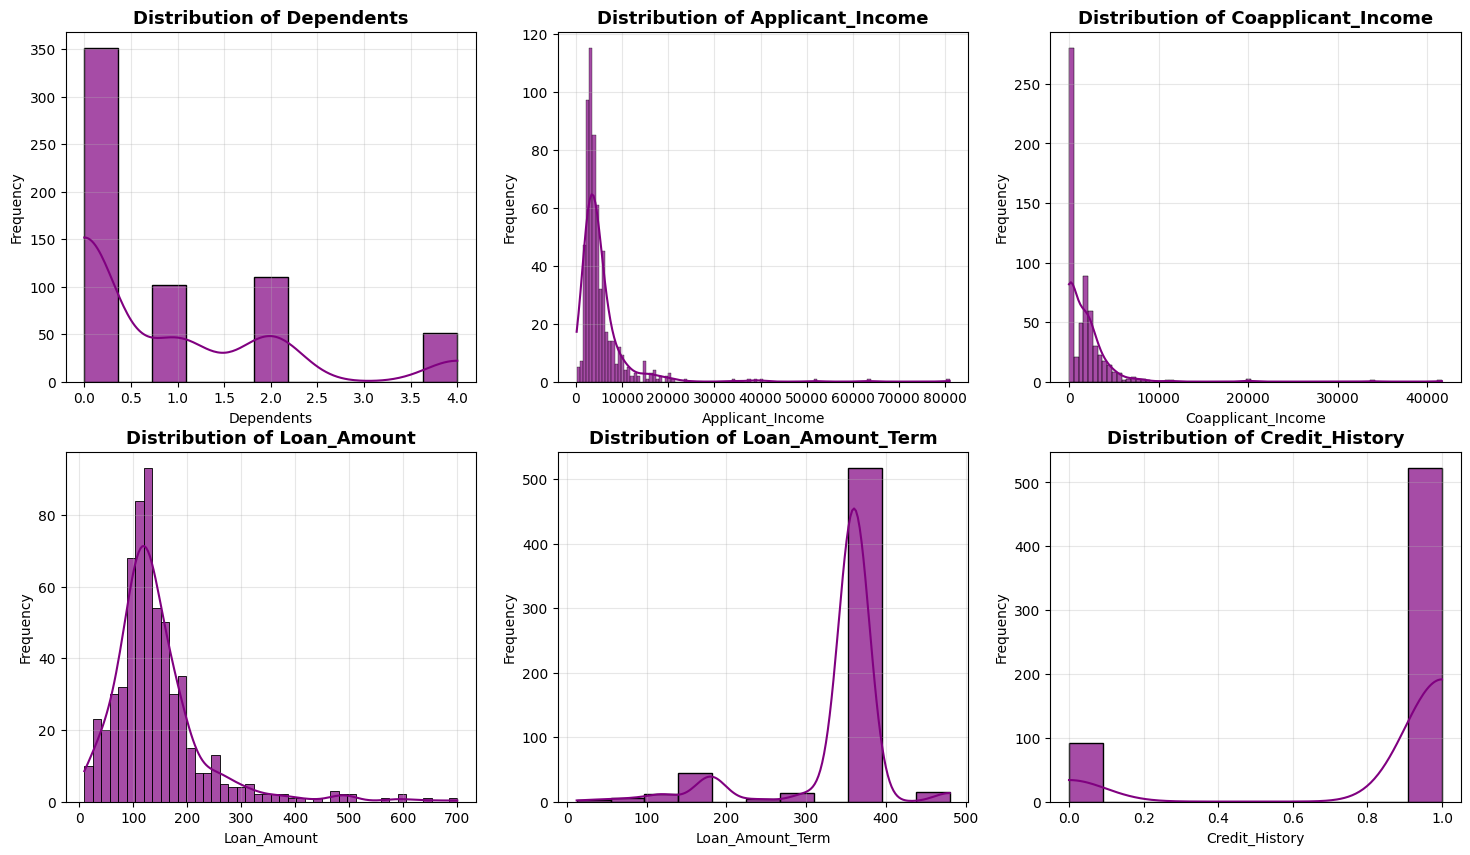

2025-11-07 18:25:07 - INFO : Distribution of numeric columns plotted!


In [66]:
log.info('='*50)
log.info('NUMERIC COLUMNS - VISUALIZATIONS')
log.info('='*50)
plt.figure(figsize=(18,10))
for i,col in enumerate(numeric_columns[1:],1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, color='purple', alpha=0.7,kde=True)
    plt.title(f'Distribution of {col}', fontsize=13, fontweight='bold')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

plt.show()
log.info(f'Distribution of numeric columns plotted!')
plt.close()

2025-11-07 18:26:49 - INFO : ==================================================
2025-11-07 18:26:49 - INFO : CATEGORICAL COLUMNS
2025-11-07 18:26:49 - INFO : ==================================================


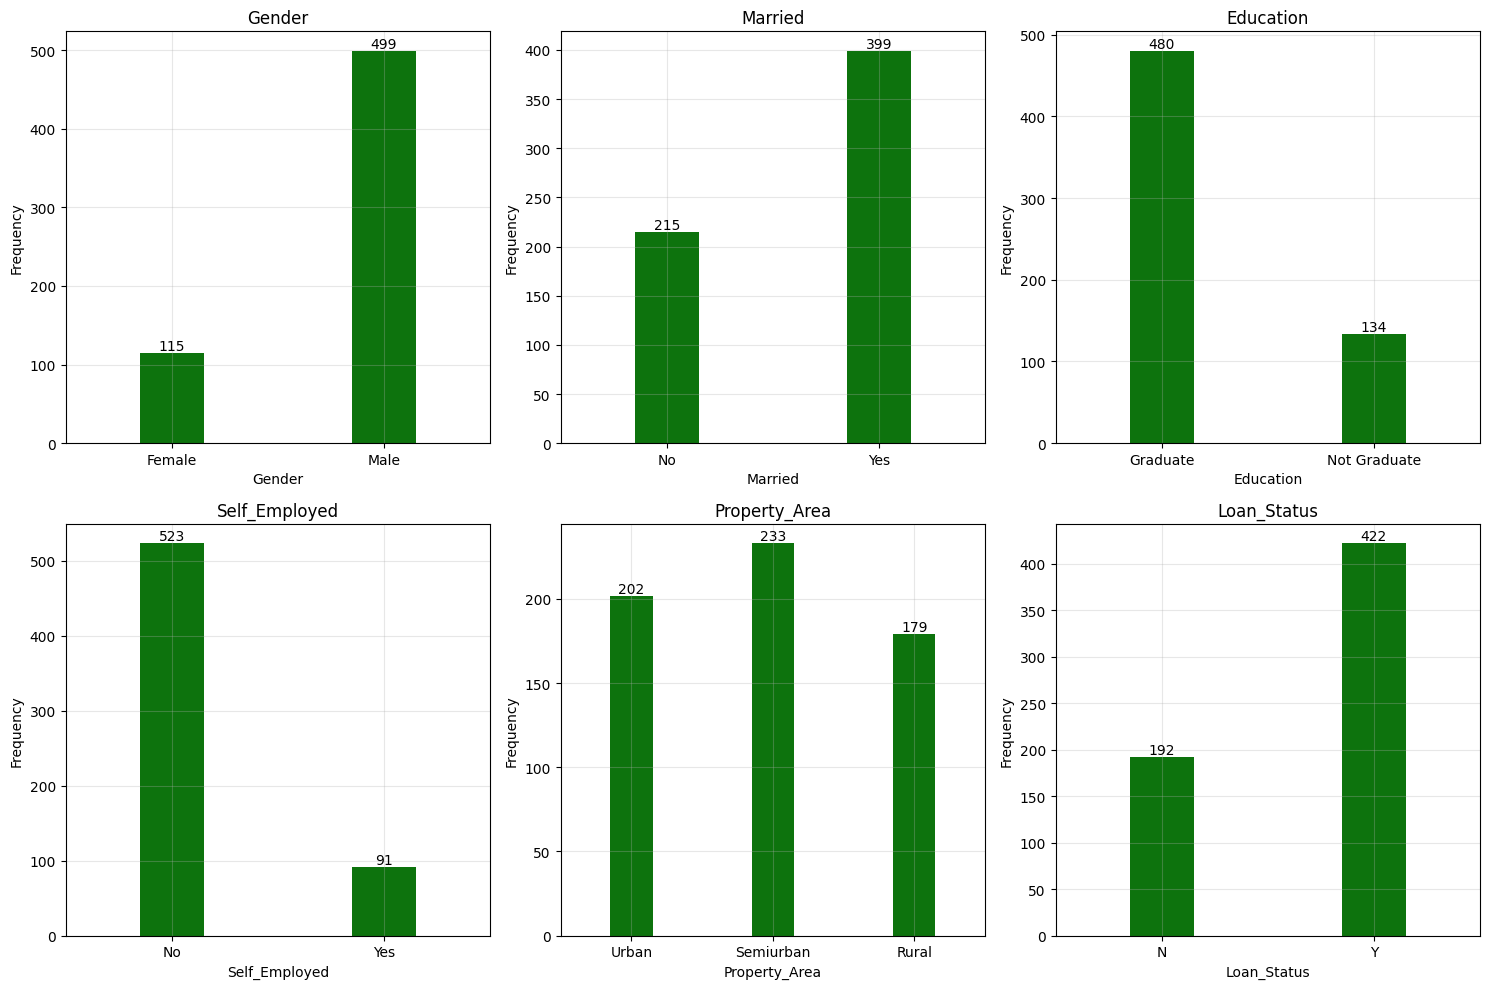

2025-11-07 18:26:51 - INFO : Categorical columns plotting successful


In [68]:
log.info('='*50)
log.info('CATEGORICAL COLUMNS')
log.info('='*50)

plt.figure(figsize=(15,10))
for i, col in enumerate(categorical_cols,1):
    plt.subplot(2, 3, i)
    ax = sns.countplot(data=df, x=col, gap=0.4, width=0.5, saturation=0.8, color='green')
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')
    ax.set_title(f'{col}')
    ax.set_ylabel('Frequency')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
log.info(f'Categorical columns plotting successful')
plt.close()